In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

sns.set_style('whitegrid')
import operator



# Definiciones Generales

### Parámetros del producto y de la demanda

In [2]:
class Product:
    def __init__(self, unit_cost, lead_time, selling_price, ordering_cost, starting_stock):
        self.unit_cost = unit_cost 
        self.lead_time = lead_time ###tiempo de entrega desde el pedido.
        self.size = 1 ### 
        self.selling_price = selling_price
        self.holding_cost = 0.3 * self.unit_cost   ###costo de almacenar una unidad un año
        self.ordering_cost = ordering_cost
        self.starting_stock = starting_stock

        self.daily_demand_mean = 8.66  ### cantidad de rollos consumidos cada dia, en promedio
        self.daily_demand_std = 6.66   ### desvio de la cant de rollos consumidos por dia
        
        self.demand_lead = self.lead_time * self.daily_demand_mean  ###rollos promedio que se van a consumir desde que se pide hasta que llega.
        
def daily_demand(mean, sd):
    d = round(np.random.normal(mean, sd),0)
    if d > 0:
        return d
    return 0

### Calcular ganancia de una corrida

In [58]:
def calculate_profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

def calculate_costs(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['units_sold']) * unit_cost

    inv_costs = Co + Ch

    return inv_costs



# Revisión Periódica (P)

### Modelado

In [112]:
def monte_carlo_ray(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.daily_demand_mean
    sd = product.daily_demand_std
    lead_time = product.lead_time
    demand_lead = product.demand_lead

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}
    

    
    for day in range(0, 365*2):
        day_demand = daily_demand(mean, sd)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            # Placing the order
            q = M - inventory + demand_lead
            order_placed = True
            data['orders'].append(q)
            
            
        if order_placed:
            counter += 1
        
        if counter == lead_time:
            # Restocking day
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

### Simulación

In [5]:
def mc_simulation(product, M, num_simulations=100):
    '''Simula n corridas para un M dado'''
    
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = monte_carlo_ray(M, product)
        # Calculating the profit
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list


def periodic_review(product, low, high, step=50):
    '''Prueba un rango de valores de M, simulando cada uno n veces''' 
    
    m_range = [i for i in range(low, high, step)]
    review_dict = {}

    for M in m_range:
        p_list, o_list = mc_simulation(product, M)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict


### Visualización de resultados

In [85]:
def plot_inventory_p(M, rp=30, product=neoprene):
    data = monte_carlo_ray(M, product, review_period=rp)
    plt.figure(figsize=(25,8))
    return plt.plot(data['inv_level'])


def plot_profit_orders_p(M, product=neoprene):
    p_list, o_list = mc_simulation(product, M, 500)
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.distplot(p_list, kde=False, ax=ax[0])
    ax[0].set_title(f'Profit Distribution : Mean {np.mean(p_list):.2f}')
    ax[0].axvline(x = np.mean(p_list), color='k', alpha = .5, ls = '--')
    sns.distplot(o_list, kde=False, ax=ax[1])
    ax[1].set_title(f'Orders Lost : Mean {np.mean(o_list):.3f}')
    ax[1].axvline(x = np.mean(o_list), color='k', alpha = .5, ls = '--')
    plt.tight_layout()
    print(np.mean(p_list), np.std(p_list))
    return


def plot_periodic_review(product, low, high, step=50):
    
    review = periodic_review(product, low, high, step)
    optimum = max(review.items(), key=operator.itemgetter(1))
    
    xx = [i for i in review.keys()]
    yy = []
    y_sd_1 = []
    y_sd_2 = []
    y_sd = []
    for val in review.values():
        yy.append(val[0])
        y_sd_1.append(val[1])
        y_sd_2.append(val[2])
        y_sd.append(val[3])

    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.plot(xx, yy, linewidth=2)
    plt.fill_between(xx, y_sd_1, y_sd_2, alpha=.25)
    plt.axvline(x = optimum[0], color='k', alpha = .5, ls = '--')

    ax.set_ylabel('Profit')
    ax.set_xlabel('M')
    ax.set_title('Simulation of Profit')



# Revisión Contínua (Q)

In [59]:
def cc_monte_carlo_ray(q, r, product):
    inventory = product.starting_stock
    mean = product.daily_demand_mean
    sd = product.daily_demand_std
    lead_time = product.lead_time

    order_placed = False
    order_time = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    #### guarda ordenes pendientes (q, fecha_llegada = fecha_pedido + lt)
    
    
    for day in range(1, 360*2):
        day_demand = daily_demand(mean, sd)
        data['daily_demand'].append(day_demand)

        if inventory <= r and not order_placed:
            # Time to place an order
            order_placed = True
            order_time = day
            
        
        ## if day in ordenes pendientes, inventory += q[arg(day)]

        if order_placed and (day-order_time) == lead_time:
            data['orders'].append(q)
            inventory += q
            order_placed = False
            order_time = 0
            
        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

### Simulación

In [60]:
def cc_mc_simulation(product, q, r, num_simulations=50):
    costs_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = cc_monte_carlo_ray(q, r, product)
        # Calculating the profit
        costs = calculate_costs(data, product)
        costs_list.append(costs)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders)

    return costs_list, orders_lost_list

def continous_review(q_range, r_range, product):
    
    review_dict = {}

    for q in q_range:
        for r in r_range:
            p_list, o_list = cc_mc_simulation(product, q, r)
            review_dict[(q, r)] = (
                np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

### Visualización de resultados

In [61]:
def plot_inventory_q(q, r, product):
    data = cc_monte_carlo_ray(q, r, product)
    plt.figure(figsize=(25,8))
    return plt.plot(data['inv_level'])

def plot_continuous_review(q_range, r_range, product):
    cc_review = continous_review(q_range, r_range, product)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    for key, val in cc_review.items():
        ax.scatter(key[0], key[1], val[0], marker = 'o')

    ax.set_xlabel('Order Quantity')
    ax.set_ylabel('Reorder Point')
    ax.set_zlabel('Profit')
    return cc_review

def plot_costs_orders_c(q,r, product):
    c_list, o_list = cc_mc_simulation(product, q, r, 500)
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.distplot(c_list, kde=False, ax=ax[0])
    ax[0].set_title(f'Distribució de los costos : Promedio {np.mean(c_list):.2f}')
    ax[0].axvline(x = np.mean(c_list), color='k', alpha = .5, ls = '--')
    sns.distplot(o_list, kde=False, ax=ax[1])
    ax[1].set_title(f'Orders Lost : Mean {np.mean(o_list):.3f}')
    ax[1].axvline(x = np.mean(o_list), color='k', alpha = .5, ls = '--')
    plt.tight_layout()
    print(np.mean(c_list), np.std(c_list))
    #f.savefig('actual.png', dpi = 200)
    return





# Resultados del modelo Q

In [72]:
def calculate_costs3(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['units_sold']) * unit_cost

    score = revenue - cost - Co - Ch
    inv_costs = Co + Ch

    return revenue/2, cost/2, Ch/2, Co/2, score/2

def cc_mc_simulation2(product, q, r, num_simulations=50):
    ventas_anuales = []
    costos_mp = []
    costos_h = []
    costos_o = []
    score = []
    ordenes_anuales = []
    ordenes_perdidas = []
    cant_ordenes = []
    inv_prom = []
    
    for sim in range(num_simulations):
        data = cc_monte_carlo_ray(q, r, product)
        # Calculating the profit
        ventas, mp, ch, co, sc = calculate_costs3(data, product)
        ventas_anuales.append(ventas)
        costos_mp.append(mp)
        costos_h.append(ch)
        costos_o.append(co)
        score.append(sc)
        ordenes_anuales.append(sum(data['daily_demand'])/2)
        ordenes_perdidas.append(sum(data['units_lost'])/2)
        cant_ordenes.append(len(data['orders'])/2)
        inv_prom.append(np.mean(data['inv_level']))
    df = pd.DataFrame({'ventas_anuales': ventas_anuales, 
                      'costos_mp': costos_mp, 
                      'costos_h': costos_h, 
                      'costos_o': costos_o, 
                      'score': score, 
                      'ordenes_anuales': ordenes_anuales, 
                      'ordenes_perdidas': ordenes_perdidas,
                      'cant_ordenes': cant_ordenes,
                      'inv_prom': inv_prom})
    return df

def plot_costs(q,r, product):
    h_list, o_list = cc_mc_simulation3(product, q, r, 500)
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.distplot(h_list, kde=False, ax=ax[0])
    ax[0].set_title(f'Costos Holdear : Promedio {np.mean(h_list):.2f}')
    ax[0].axvline(x = np.mean(h_list), color='k', alpha = .5, ls = '--')
    sns.distplot(o_list, kde=False, ax=ax[1])
    ax[1].set_title(f'Costos Pedir : Mean {np.mean(o_list):.3f}')
    ax[1].axvline(x = np.mean(o_list), color='k', alpha = .5, ls = '--')
    plt.tight_layout()
    #print(np.mean(h_list), np.std(h_list))
    #f.savefig('actual.png', dpi = 200)
    return

In [78]:
neoprene = Product(unit_cost = 2460, 
                       lead_time = 151, 
                       selling_price = 13750, 
                       ordering_cost = 1600000, 
                       starting_stock = 2000)



df_actual = cc_mc_simulation2(neoprene, 2000, 1300)
df_opt = cc_mc_simulation2(neoprene, 2450, 1450)

df_opt


,ventas_anuales,costos_mp,costos_h,costos_o,score,ordenes_anuales,ordenes_perdidas,cant_ordenes,inv_prom
0,45010625.0,8052810.0,9.039287e+05,1600000.0,3.445389e+07,3285.5,12.0,2,1243.574409
1,43560000.0,7793280.0,9.431569e+05,1600000.0,3.322356e+07,3168.0,0.0,2,1297.542420
2,43216250.0,7731780.0,9.403000e+05,1600000.0,3.294417e+07,3171.0,28.0,2,1293.611961
3,45196250.0,8086020.0,8.991357e+05,1600000.0,3.461109e+07,3329.0,42.0,2,1236.980529
4,46729375.0,8360310.0,8.581798e+05,1600000.0,3.591089e+07,3432.0,33.5,2,1180.635605
5,44735625.0,8003610.0,9.600076e+05,1600000.0,3.417201e+07,3253.5,0.0,2,1320.724618
6,43560000.0,7793280.0,9.723827e+05,1600000.0,3.319434e+07,3168.0,0.0,2,1337.749652
7,43319375.0,7750230.0,9.482805e+05,1600000.0,3.302086e+07,3150.5,0.0,2,1304.591099
8,43670000.0,7812960.0,9.676565e+05,1600000.0,3.328938e+07,3176.0,0.0,2,1331.247566
9,44508750.0,7963020.0,9.125906e+05,1600000.0,3.403314e+07,3237.0,0.0,2,1255.490960


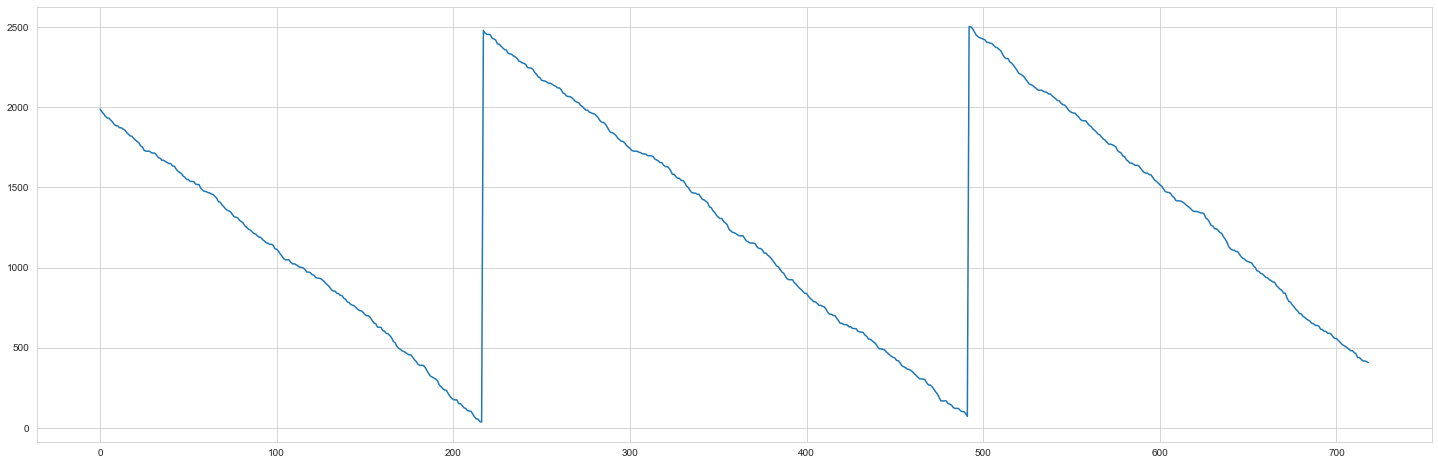

In [79]:
data = cc_monte_carlo_ray(2450, 1450, neoprene)

plot_inventory_q(2450, 1450, neoprene)

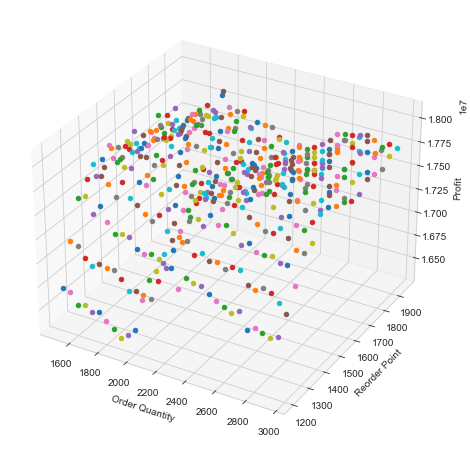

In [59]:
q_range = list(range(1500, 3000, 50))
r_range = list(range(1200,2000,50))

resultados = plot_continuous_review(q_range, r_range, neoprene)

# Resultados del modelo P

In [99]:
def calculate_costs3(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['units_sold']) * unit_cost

    score = revenue - cost - Co - Ch
    inv_costs = Co + Ch

    return revenue/3, cost/3, Ch/3, Co/3, score/3

def p_mc_simulation2(product, M, rp, num_simulations=50):
    ventas_anuales = []
    costos_mp = []
    costos_h = []
    costos_o = []
    score = []
    ordenes_anuales = []
    ordenes_perdidas = []
    cant_ordenes = []
    inv_prom = []
    
    for sim in range(num_simulations):
        data = monte_carlo_ray(M, product, rp)
        # Calculating the profit
        ventas, mp, ch, co, sc = calculate_costs3(data, product)
        ventas_anuales.append(ventas)
        costos_mp.append(mp)
        costos_h.append(ch)
        costos_o.append(co)
        score.append(sc)
        ordenes_anuales.append(sum(data['daily_demand'])/3)
        ordenes_perdidas.append(sum(data['units_lost'])/3)
        cant_ordenes.append(len(data['orders'])/3)
        inv_prom.append(np.mean(data['inv_level']))
    df = pd.DataFrame({'ventas_anuales': ventas_anuales, 
                      'costos_mp': costos_mp, 
                      'costos_h': costos_h, 
                      'costos_o': costos_o, 
                      'score': score, 
                      'ordenes_anuales': ordenes_anuales, 
                      'ordenes_perdidas': ordenes_perdidas,
                      'cant_ordenes': cant_ordenes,
                      'inv_prom': inv_prom})
    return df


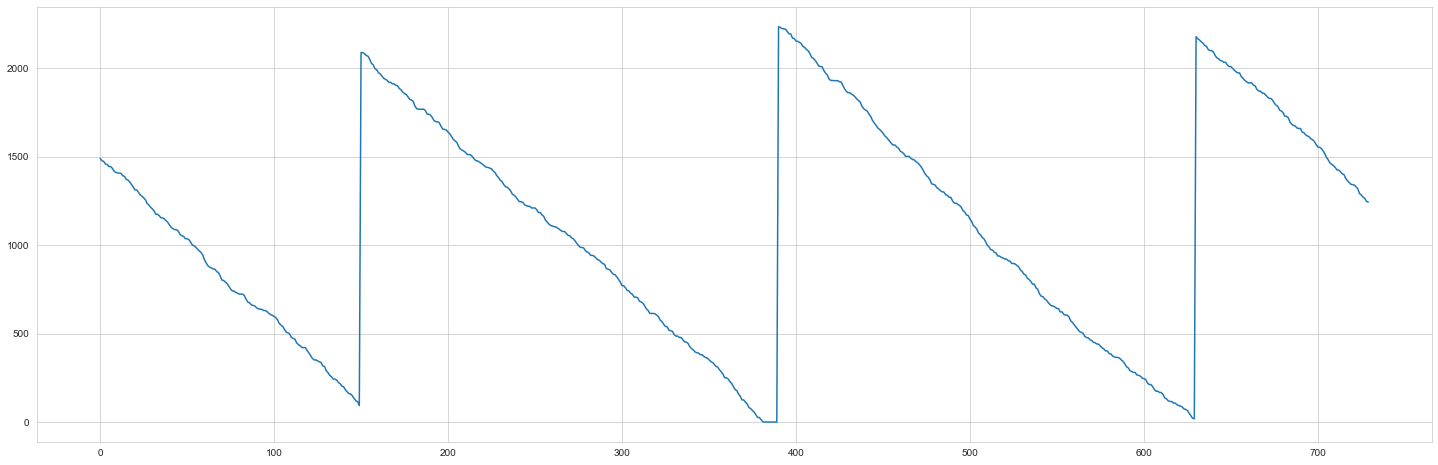

In [115]:
neoprene = Product(unit_cost = 2460, 
                       lead_time = 151, 
                       selling_price = 13750, 
                       ordering_cost = 1600000, 
                       starting_stock = 1500)

plot_inventory_p(2200, 240, neoprene)

p_mc_simulation2(neoprene, 2100, 180).to_excel('optimo_p.xlsx')

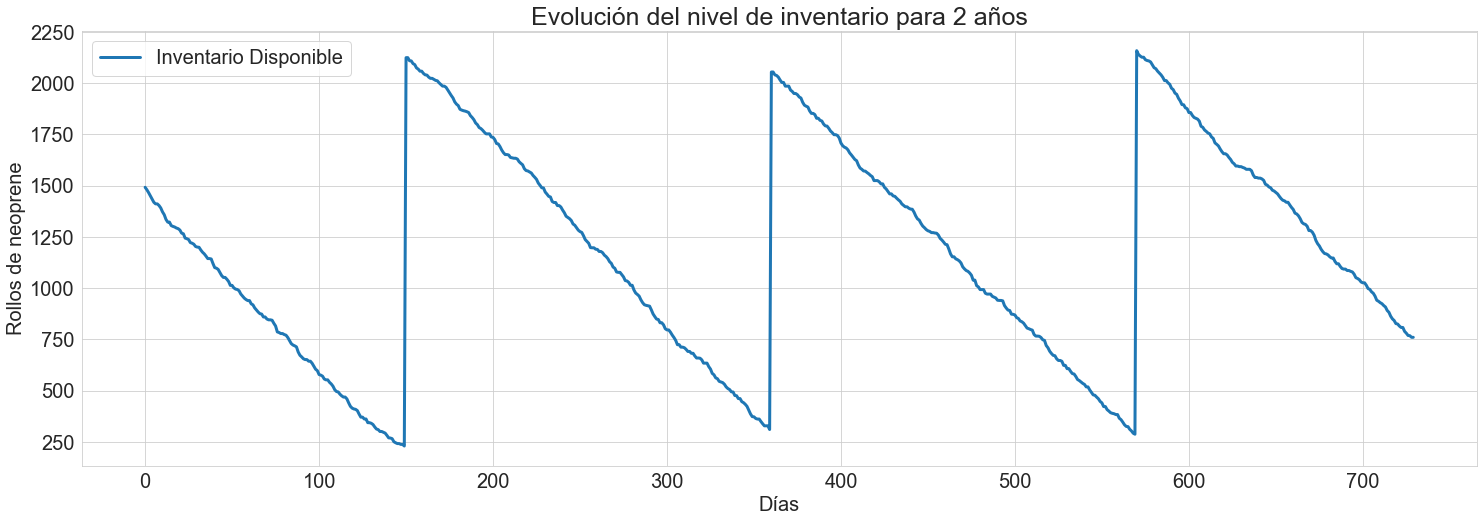

In [117]:
data = monte_carlo_ray(2100, neoprene, 210)
plt.figure(figsize=(25,8))
plt.plot(data['inv_level'], label = 'Inventario Disponible', lw=3)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Evolución del nivel de inventario para 2 años', fontsize=25)
plt.xlabel('Días', fontsize=20)
plt.ylabel('Rollos de neoprene', fontsize=20)
plt.legend(fontsize=20, loc='upper left')
plt.savefig('inventario modelo P.png', dpi=250)

df = pd.DataFrame(data['inv_level'])
df.to_excel('inventario P.xlsx')
